We are implementing 2 models, that we talked about in our course: Pix2Pix and CycleGAN. In order for this notebook to work, it has to have dataset folder from the course in the same folder, with "train", "val" and "test" inside.

In this case, we are solving segmentation problem using generative models.

# Imports
in the following part we are importing all the necessary packages for data processing and models' implementation. images have to be prepared differently for both models.

In [47]:
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from tqdm import tqdm
from torch.nn.modules.conv import ConvTranspose2d
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToPILImage
from torchvision.utils import save_image
from yacs.config import CfgNode

# configuration data for image preparation and model initialization and training

We initialize a configuration storage with yacs package, a good utility for storing configuration information.
Also we create subnodes in our storage to store specific information for each model

In [35]:
cfg = CfgNode()
cfg.GENERAL = CfgNode()
cfg.PIX2PIX = CfgNode()
cfg.CYCLEGAN = CfgNode()

in case we can use gpu for calculations, we set device as cuda and store basic image width and height. Also we set number of epochs of 100 and learning rate as 2e-4

In [36]:
cfg.GENERAL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

cfg.GENERAL.IMAGE_W = 256
cfg.GENERAL.IMAGE_H = 256
cfg.GENERAL.NUM_EPOCHS = 100
cfg.GENERAL.NUM_WORKERS = 0
cfg.GENERAL.LR = 2e-4

setting up paths for 2 datasets. Pix2pix can use the raw images, but images for CycleGAN should be preprocessed differently, so we create separate folders for that.

In [37]:
cfg.GENERAL.DATA_PATH = "facades"

cfg.GENERAL.TRAIN_DATA_PATH = os.path.join(cfg.GENERAL.DATA_PATH, 'train')
cfg.GENERAL.VAL_DATA_PATH = os.path.join(cfg.GENERAL.DATA_PATH, 'val')
cfg.GENERAL.TEST_DATA_PATH = os.path.join(cfg.GENERAL.DATA_PATH, 'test')
cfg.GENERAL.PROJECT_RESULTS_PATH = "results"
cfg.GENERAL.PROJECT_CHECKPOINTS_PATH = "checkpoints"

cfg.PIX2PIX.TRAIN_DATA_PATH = cfg.GENERAL.TRAIN_DATA_PATH
cfg.PIX2PIX.VAL_DATA_PATH = cfg.GENERAL.VAL_DATA_PATH
cfg.PIX2PIX.TEST_DATA_PATH = cfg.GENERAL.TEST_DATA_PATH


cfg.PIX2PIX.RESULTS_PATH = os.path.join(cfg.GENERAL.PROJECT_RESULTS_PATH, 'pix2pix')
cfg.PIX2PIX.CHECKPOINTS_PATH = os.path.join(cfg.GENERAL.PROJECT_CHECKPOINTS_PATH, 'pix2pix')

cfg.CYCLEGAN.DATA_PATH = 'facades/cyclegan'
cfg.CYCLEGAN.TRAIN_DATA_PATH = os.path.join(cfg.CYCLEGAN.DATA_PATH, 'train')
cfg.CYCLEGAN.VAL_DATA_PATH = os.path.join(cfg.CYCLEGAN.DATA_PATH, 'val')
cfg.CYCLEGAN.TEST_DATA_PATH = os.path.join(cfg.CYCLEGAN.DATA_PATH, 'test')

cfg.CYCLEGAN.PHOTO_TRAIN_PATH = os.path.join(cfg.CYCLEGAN.TRAIN_DATA_PATH, 'photo')
cfg.CYCLEGAN.PHOTO_VAL_PATH = os.path.join(cfg.CYCLEGAN.VAL_DATA_PATH, 'photo')
cfg.CYCLEGAN.PHOTO_TEST_PATH = os.path.join(cfg.CYCLEGAN.TEST_DATA_PATH, 'photo')

cfg.CYCLEGAN.SEGMENTATION_TRAIN_PATH = os.path.join(cfg.CYCLEGAN.TRAIN_DATA_PATH, 'segmentation')
cfg.CYCLEGAN.SEGMENTATION_VAL_PATH = os.path.join(cfg.CYCLEGAN.VAL_DATA_PATH, 'segmentation')
cfg.CYCLEGAN.SEGMENTATION_TEST_PATH = os.path.join(cfg.CYCLEGAN.TEST_DATA_PATH, 'segmentation')
cfg.CYCLEGAN.RESULTS_PATH = os.path.join(cfg.GENERAL.PROJECT_RESULTS_PATH, 'cyclegan')
cfg.CYCLEGAN.CHECKPOINTS_PATH = os.path.join(cfg.GENERAL.PROJECT_CHECKPOINTS_PATH, 'cyclegan')

Also, we setup parameters for dataloaders and specific training parameters.

In [38]:
cfg.PIX2PIX.TRAIN_BATCH_SIZE = 16
cfg.PIX2PIX.VAL_BATCH_SIZE = 5
cfg.PIX2PIX.LAMBDA = 100

cfg.CYCLEGAN.TRAIN_BATCH_SIZE = 5
cfg.CYCLEGAN.VAL_BATCH_SIZE = 5
cfg.CYCLEGAN.LAMBDA_CYCLE = 10
cfg.CYCLEGAN.LAMBDA_IDENTITY = 0.5 * cfg.CYCLEGAN.LAMBDA_CYCLE

# Image preparation
Images can be taken almost raw by pix2pix, yet in the case of CycleGAN we should preprocess them differently.


First, we create necessary directories, if they dont exist

In [39]:
#general
if not os.path.exists(cfg.GENERAL.PROJECT_RESULTS_PATH):
    os.mkdir(cfg.GENERAL.PROJECT_RESULTS_PATH)
if not os.path.exists(cfg.GENERAL.PROJECT_CHECKPOINTS_PATH):
    os.mkdir(cfg.GENERAL.PROJECT_CHECKPOINTS_PATH)
#pix2pix
if not os.path.exists(cfg.PIX2PIX.RESULTS_PATH):
    os.mkdir(cfg.PIX2PIX.RESULTS_PATH)
if not os.path.exists(cfg.PIX2PIX.CHECKPOINTS_PATH):
    os.mkdir(cfg.PIX2PIX.CHECKPOINTS_PATH)
#cyclegan general
if not os.path.exists(cfg.CYCLEGAN.RESULTS_PATH):
    os.mkdir(cfg.CYCLEGAN.RESULTS_PATH)
if not os.path.exists(cfg.CYCLEGAN.CHECKPOINTS_PATH):
    os.mkdir(cfg.CYCLEGAN.CHECKPOINTS_PATH)
if not os.path.exists(cfg.CYCLEGAN.DATA_PATH):
    os.mkdir(cfg.CYCLEGAN.DATA_PATH)
#cyclegan train/test/val 
if not os.path.exists(cfg.CYCLEGAN.TRAIN_DATA_PATH):
    os.mkdir(cfg.CYCLEGAN.TRAIN_DATA_PATH)
if not os.path.exists(cfg.CYCLEGAN.VAL_DATA_PATH):
    os.mkdir(cfg.CYCLEGAN.VAL_DATA_PATH)
if not os.path.exists(cfg.CYCLEGAN.TEST_DATA_PATH):
    os.mkdir(cfg.CYCLEGAN.TEST_DATA_PATH)
#specifics(photo/seg)
if not os.path.exists(cfg.CYCLEGAN.PHOTO_TRAIN_PATH):
    os.mkdir(cfg.CYCLEGAN.PHOTO_TRAIN_PATH)
if not os.path.exists(cfg.CYCLEGAN.PHOTO_VAL_PATH):
    os.mkdir(cfg.CYCLEGAN.PHOTO_VAL_PATH)
if not os.path.exists(cfg.CYCLEGAN.PHOTO_TEST_PATH):
    os.mkdir(cfg.CYCLEGAN.PHOTO_TEST_PATH)
if not os.path.exists(cfg.CYCLEGAN.SEGMENTATION_TRAIN_PATH):
    os.mkdir(cfg.CYCLEGAN.SEGMENTATION_TRAIN_PATH)
if not os.path.exists(cfg.CYCLEGAN.SEGMENTATION_VAL_PATH):
    os.mkdir(cfg.CYCLEGAN.SEGMENTATION_VAL_PATH)
if not os.path.exists(cfg.CYCLEGAN.SEGMENTATION_TEST_PATH):
    os.mkdir(cfg.CYCLEGAN.SEGMENTATION_TEST_PATH)

lets separate images from raw to photos and segmentations for CycleGAN model.

In [40]:
for img_name in os.listdir(cfg.GENERAL.TRAIN_DATA_PATH):
    img_path = os.path.join(cfg.GENERAL.TRAIN_DATA_PATH, img_name)
    photo_path = os.path.join(cfg.CYCLEGAN.PHOTO_TRAIN_PATH, img_name)
    segmentation_path = os.path.join(cfg.CYCLEGAN.SEGMENTATION_TRAIN_PATH, img_name)

    img = Image.open(img_path)
    img.crop((0, 0, 256, 256)).save(photo_path)
    img.crop((256, 0, 512, 256)).save(segmentation_path)

for img_name in os.listdir(cfg.GENERAL.VAL_DATA_PATH):
    img_path = os.path.join(cfg.GENERAL.VAL_DATA_PATH, img_name)
    photo_path = os.path.join(cfg.CYCLEGAN.PHOTO_VAL_PATH, img_name)
    segmentation_path = os.path.join(cfg.CYCLEGAN.SEGMENTATION_VAL_PATH, img_name)

    img = Image.open(img_path)
    img.crop((0, 0, 256, 256)).save(photo_path)
    img.crop((256, 0, 512, 256)).save(segmentation_path)

for img_name in os.listdir(cfg.GENERAL.TEST_DATA_PATH):
    img_path = os.path.join(cfg.GENERAL.TEST_DATA_PATH, img_name)
    photo_path = os.path.join(cfg.CYCLEGAN.PHOTO_TEST_PATH, img_name)
    segmentation_path = os.path.join(cfg.CYCLEGAN.SEGMENTATION_TEST_PATH, img_name)

    img = Image.open(img_path)
    img.crop((0, 0, 256, 256)).save(photo_path)
    img.crop((256, 0, 512, 256)).save(segmentation_path)

## Pix2Pix
We need to implement several functions in order for our training process to be smooth.

First, we need to define a dataset.

In [41]:
trans = A.Compose([
    A.Resize(width=cfg.GENERAL.IMAGE_W, height=cfg.GENERAL.IMAGE_H),
    A.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5], max_pixel_value=255.0),
    ToTensorV2()
    ])
class FacadeDataset(Dataset):

    def __init__(self, data_folder=cfg.GENERAL.TRAIN_DATA_PATH):
        super().__init__()
        self.data_folder = data_folder
        self.image_files = os.listdir(data_folder)

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.data_folder, image_file)
        image = np.array(Image.open(image_path))
        image, target = image[:, :cfg.GENERAL.IMAGE_W, :], image[:, cfg.GENERAL.IMAGE_W:, :]

        image = trans(image=image)['image']
        target = trans(image=target)['image']

        return image, target


## here we implement a function that will save a model after training and validation function.
 during validation we print the real image, the target segmentation and resulting segmentation of our generator. We will be outputting generated mask and the ground truth mask as a single image to facilitate the evaluation

In [57]:
def save_model(model, optim, project_path, name):
    model_path = os.path.join(project_path, name)
    model_data = {'model': model.state_dict(), 'optim': optim.state_dict()}
    torch.save(model_data, model_path)

def validate_generator(G, loader, results_path):
    G.eval()
    to_pil_transform = ToPILImage()
    x, y = next(iter(loader))
    x, y = x.to(cfg.GENERAL.DEVICE), y.to(cfg.GENERAL.DEVICE)
    with torch.inference_mode():
        y_fake = G(x)
    
    norm_tensor = torch.FloatTensor([[[.5]], [[.5]], [[.5]]]).to(cfg.GENERAL.DEVICE)
    
    y = torch.concat(torch.tensor_split(y, y.shape[0]), 3).squeeze() * norm_tensor + norm_tensor
    y_fake = torch.concat(torch.tensor_split(y_fake, y_fake.shape[0]), 3).squeeze() * norm_tensor + norm_tensor
    output = torch.cat([y, y_fake], dim=1)
    print(f"Results:")
    display(to_pil_transform(output))

    image_path = os.path.join(results_path, 'result.png')
    save_image(output, image_path)

## Discriminator class
We define here discriminator for pix2pix model. It will be using a simple conv layer first, then 3 blocks with increasing number of channels and final block with sigmoid.

In [43]:
class Discriminator(nn.Module):
    def __init__(self, in_c = 3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_c*2, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, bias=False, padding=1, padding_mode="reflect"),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, bias=False, padding=1, padding_mode="reflect"),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, bias=False, padding=1, padding_mode="reflect"),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
            nn.Sigmoid()
        )
    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        return self.model(x)

## Generator class
As our generator, we will define a decoder/encoder block in one go: when we encode the image, we will use LeakyRelu as function, but while decoding we will use simple ReLU and optionally will use some dropouts on several layers. We will be using an architecture of the Unet Generator model, that will use skip connections.

In [52]:
class DeencoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, activation="ReLU", drop=False):
        super().__init__()
        self.encb = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False, padding_mode="reflect")
            if downsample
            else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU() if activation=="ReLU" else nn.LeakyReLU(0.2)
        )
        self.drop = drop
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        if self.drop:
            return self.dropout(self.encb(x))
        else:
            return self.encb(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        # Downsample part of the generator (similar to UNet)
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        self.enc2 = DeencoderBlock(in_channels=64, out_channels=128, downsample=True, activation="Leaky", drop=False)
        self.enc3 = DeencoderBlock(in_channels=128, out_channels=256, downsample=True, activation="Leaky", drop=False)
        self.enc4 = DeencoderBlock(in_channels=256, out_channels=512, downsample=True, activation="Leaky", drop=False)
        self.enc5 = DeencoderBlock(in_channels=512, out_channels=512, downsample=True, activation="Leaky", drop=False)
        self.enc6 = DeencoderBlock(in_channels=512, out_channels=512, downsample=True, activation="Leaky", drop=False)
        self.enc7 = DeencoderBlock(in_channels=512, out_channels=512, downsample=True, activation="Leaky", drop=False)
        self.bottle = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.ReLU()
        )
        self.dec1 = DeencoderBlock(in_channels=512, out_channels=512, downsample=False, activation="ReLU", drop=True)
        self.dec2 = DeencoderBlock(in_channels=1024, out_channels=512, downsample=False, activation="ReLU", drop=True)
        self.dec3 = DeencoderBlock(in_channels=1024, out_channels=512, downsample=False, activation="ReLU", drop=True)
        self.dec4 = DeencoderBlock(in_channels=1024, out_channels=512, downsample=False, activation="ReLU", drop=True)
        self.dec5 = DeencoderBlock(in_channels=1024, out_channels=256, downsample=False, activation="ReLU", drop=False)
        self.dec6 = DeencoderBlock(in_channels=512, out_channels=128, downsample=False, activation="ReLU", drop=False)
        self.dec7 = DeencoderBlock(in_channels=256, out_channels=64, downsample=False, activation="ReLU", drop=False)
        self.out = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        enc7 = self.enc7(enc6)
        bottle = self.bottle(enc7)
        dec1 = self.dec1(bottle)
        dec2 = self.dec2(torch.cat([dec1, enc7], dim=1))
        dec3 = self.dec3(torch.cat([dec2, enc6], dim=1))
        dec4 = self.dec4(torch.cat([dec3, enc5], dim=1))
        dec5 = self.dec5(torch.cat([dec4, enc4], dim=1))
        dec6 = self.dec6(torch.cat([dec5, enc3], dim=1))
        dec7 = self.dec7(torch.cat([dec6, enc2], dim=1))
        out = self.out(torch.cat([dec7, enc1], dim=1))
        return out

## Training process
during training, we use a L1 loss for generator and a simple loss for discriminator(comparing real images and generated images and computing the sum of respective losses).

1. First, we pass real images through the discriminator and calculate loss.
2. Then, we generate images with the generator.
3. Then, pass generated images through discriminator and calculate loss.
4. make a step in training the discriminator.
5. Train the generator to make him be able to create better images, so the discriminator doesn't spot the difference.

In [53]:
def train_step(D, D_optim, G, G_optim, loader, bce_loss, l1_loss):
    #enable generator and discriminator to train
    D.train()
    G.train()
    #iterate over our data
    for x, y in tqdm(loader):
        x, y = x.to(cfg.GENERAL.DEVICE), y.to(cfg.GENERAL.DEVICE)
        #1
        D_real_pred = D(x, y) 
        D_real_loss = bce_loss(D_real_pred, torch.ones_like(D_real_pred))
        #2
        y_fake = G(x)
        #3
        D_fake_pred = D(x, y_fake.detach())
        D_fake_loss = bce_loss(D_fake_pred, torch.zeros_like(D_fake_pred))
        D_loss = D_real_loss + D_fake_loss
        #4
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        #5
        D_fake_pred = D(x, y_fake.detach())
        G_fake_loss = bce_loss(D_fake_pred, torch.ones_like(D_fake_pred))
        L1 = l1_loss(y_fake, y) * cfg.PIX2PIX.LAMBDA
        G_loss = G_fake_loss + L1
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

### Training of the pix2pix model.
1. initialize discriminator and generator.
2. initialize optimizers and losses.
3. create datasets and loaders.
4. Train and save models after.

In [54]:
D = Discriminator().to(cfg.GENERAL.DEVICE)
G = Generator().to(cfg.GENERAL.DEVICE)

D_optim = optim.Adam(D.parameters(), lr=cfg.GENERAL.LR, betas=(0.5, 0.999))
G_optim = optim.Adam(G.parameters(), lr=cfg.GENERAL.LR, betas=(0.5, 0.999))
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

train_dataset = FacadeDataset()
train_dataloader = DataLoader(train_dataset, batch_size=cfg.PIX2PIX.TRAIN_BATCH_SIZE, shuffle=True, num_workers=cfg.GENERAL.NUM_WORKERS)
val_dataset = FacadeDataset(cfg.GENERAL.VAL_DATA_PATH)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.PIX2PIX.VAL_BATCH_SIZE, shuffle=False, num_workers=cfg.GENERAL.NUM_WORKERS)

for epoch in tqdm(range(cfg.GENERAL.NUM_EPOCHS)):
    train_step(D, D_optim, G, G_optim, train_dataloader, bce_loss, l1_loss)

100%|██████████████████████████████████████████████████████████| 100/100 [5:56:30<00:00, 213.91s/it]


Lets save resulting models and see how it works

In [55]:
save_model(D, D_optim, cfg.PIX2PIX.CHECKPOINTS_PATH, 'discriminator_final.pth')
save_model(G, G_optim, cfg.PIX2PIX.CHECKPOINTS_PATH, 'generator_final.pth')

Results:


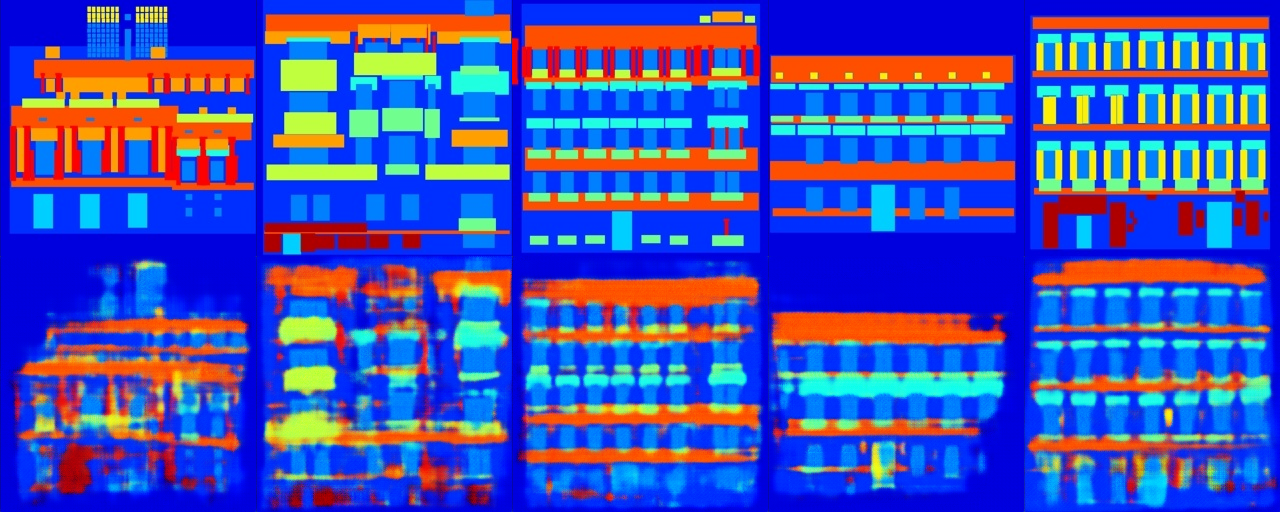

In [58]:
validate_generator(G, val_dataloader, cfg.PIX2PIX.RESULTS_PATH)

## 3. Training CycleGAN 

This section is dedicated to CycleGAN implementation. Here I implement:

1. Dataset class for facades
1. Discriminator class
1. Generator class
1. Train step function
1. Train function
1. Visualization function for the results
### P.S. we use the same preprocessing transforms as we used in Pix2Pix dataset.

In [70]:
class PhotoSegmentationDataset(Dataset):
    def __init__(self, photo_folder, segmentation_folder, shuffle_segmentation=True):
        super().__init__()
        self.photo_folder = photo_folder
        self.segmentation_folder = segmentation_folder

        self.photo_files = os.listdir(self.photo_folder)
        self.segmentation_files = os.listdir(self.segmentation_folder)
        if shuffle_segmentation:
            random.shuffle(self.segmentation_files)

    def __len__(self):
        # I can specify length like this, because I know that my photo and segmentation datasets have equal length
        return len(self.photo_files)

    def __getitem__(self, idx):
        photo_file = self.photo_files[idx]
        segmentation_file = self.segmentation_files[idx]

        photo_image_path = os.path.join(self.photo_folder, photo_file)
        segmentation_image_path = os.path.join(self.segmentation_folder, segmentation_file)

        photo_image = np.array(Image.open(photo_image_path).convert('RGB'))
        segmentation_image = np.array(Image.open(segmentation_image_path).convert('RGB'))

        photo_image = trans(image=photo_image)['image']
        segmentation_image = trans(image=segmentation_image)['image']

        return photo_image, segmentation_image

# Discriminator
as a discriminator, we will be using the same discriminator, as we used for pix2pix model, but just applied for a single image, not stitched. In the article they suggested to use Instancenorm instead of batch, but I decided to stick to basics.

In [77]:
class Discriminator(nn.Module):
    def __init__(self, in_c = 3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_c, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, bias=False, padding=1, padding_mode="reflect"),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, bias=False, padding=1, padding_mode="reflect"),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, bias=False, padding=1, padding_mode="reflect"),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# Generator
For our generator we will add 2 submodels: Convolution block and Residual block to simplify the structure of our model and make it easier to read.

In [78]:
class deencConv(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=True, use_activation=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, padding_mode="reflect", **kwargs)
            if downsample
            else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, **kwargs),
            nn.InstanceNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True) if use_activation else nn.Identity()
        )
    
    def forward(self, x):
        return self.conv(x)

class deencRes(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            GeneratorConvBlock(channels, channels, kernel_size=3, padding=1),
            GeneratorConvBlock(channels, channels, use_activation=False, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        return x + self.block(x)

## Generator model
we apply the same idea of Unet with resudials: decoding and encoding

In [79]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, num_residuals=9):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True),
            deencConv(in_channels=out_channels, out_channels=out_channels*2, kernel_size=3, stride=2, padding=1),
            deencConv(in_channels=out_channels*2, out_channels=out_channels*4, kernel_size=3, stride=2, padding=1)
        )

        self.res = nn.Sequential(
            *[deencRes(channels=out_channels*4) for _ in range(num_residuals)]
        )

        self.dec = nn.Sequential(
            deencConv(in_channels=out_channels*4, out_channels=out_channels*2, downsample=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            deencConv(in_channels=out_channels*2, out_channels=out_channels, downsample=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.Tanh()
        )

    def forward(self, x):
        return self.dec(self.res(self.enc(x)))

# Training step
during training, we we do the following:
1. Take real photos and segmentations
2. Generate fake photo and segmentation from real ones.
3.  Discriminator processes real and fake photos, and also real and fake segmentations
4. Calculate losses
5. Make a training step with resulting loss
6. Do the same with fake generated photos and segmentations
7. Make a training step for Generator

In [82]:
def train_step(D_photo, D_segmentation, D_optim, G_photo, G_segmentation, G_optim, loader, mse_loss, l1_loss):
    D_photo.train()
    D_segmentation.train()
    G_photo.train()
    G_segmentation.train()
    for photo, segmentation in tqdm(loader):
        #1
        photo_real, segmentation_real = photo.to(cfg.GENERAL.DEVICE), segmentation.to(cfg.GENERAL.DEVICE)
        #2
        photo_fake = G_photo(segmentation_real)
        segmentation_fake = G_segmentation(photo_real)
        #3
        D_photo_pred_real = D_photo(photo_real)
        D_photo_pred_fake = D_photo(photo_fake.detach())
        #4
        D_segmentation_pred_real = D_segmentation(segmentation_real)
        D_segmentation_pred_fake = D_segmentation(segmentation_fake.detach())
        D_photo_loss_real = mse_loss(D_photo_pred_real, torch.ones_like(D_photo_pred_real))
        D_photo_loss_fake = mse_loss(D_photo_pred_fake, torch.zeros_like(D_photo_pred_fake))
        D_photo_loss = D_photo_loss_real + D_photo_loss_fake
        D_segmentation_loss_real = mse_loss(D_segmentation_pred_real, torch.ones_like(D_segmentation_pred_real))
        D_segmentation_loss_fake = mse_loss(D_segmentation_pred_fake, torch.zeros_like(D_segmentation_pred_fake))
        D_segmentation_loss = D_segmentation_loss_real + D_segmentation_loss_fake
        D_loss = (D_photo_loss + D_segmentation_loss) / 2
        #5
        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()
        #6
        D_photo_pred_fake = D_photo(photo_fake)
        D_segmentation_pred_fake = D_segmentation(segmentation_fake)

        D_photo_loss_fake = mse_loss(D_photo_pred_fake, torch.ones_like(D_photo_pred_fake))
        D_segmentation_loss_fake = mse_loss(D_segmentation_pred_fake, torch.ones_like(D_segmentation_pred_fake))
        segmentation_fake_fake = G_segmentation(photo_fake)
        photo_fake_fake = G_photo(segmentation_fake)

        phote_fake_fake_loss = l1_loss(photo_real, photo_fake_fake)
        segmentation_fake_fake_loss = l1_loss(segmentation_real, segmentation_fake_fake)
        photo_real_real = G_photo(photo_real)
        segmentation_real_real = G_segmentation(segmentation_real)

        photo_real_real_loss = l1_loss(photo_real, photo_real_real)
        segmentation_real_real_loss = l1_loss(segmentation_real, segmentation_real_real)
        
        G_loss = (D_photo_loss_fake + D_segmentation_loss_fake
                  + phote_fake_fake_loss * cfg.CYCLEGAN.LAMBDA_CYCLE
                  + segmentation_fake_fake_loss * cfg.CYCLEGAN.LAMBDA_CYCLE
                  + photo_real_real_loss * cfg.CYCLEGAN.LAMBDA_IDENTITY
                  + segmentation_real_real_loss * cfg.CYCLEGAN.LAMBDA_IDENTITY)
        
        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()


# Training
1. Initialize Discriminators for images and segmentations
2. Initalize Generators for images and segmentations
3. Initialize optimizers and loss functions
4. create datasets and loaders
5. Train for desired number of epochs.
#### Unfortunately, The training is taking way too long, 1 epoch literally takes 1 hour with my computer. I hope this is not the problem, since the training process has been established.

In [84]:
#1
D_photo = Discriminator().to(cfg.GENERAL.DEVICE)
D_segmentation = Discriminator().to(cfg.GENERAL.DEVICE)
#2
G_photo = Generator().to(cfg.GENERAL.DEVICE)
G_segmentation = Generator().to(cfg.GENERAL.DEVICE)
#3
D_optim = optim.Adam(list(D_photo.parameters()) + list(D_segmentation.parameters()), lr=cfg.GENERAL.LR, betas=(0.5, 0.999))
G_optim = optim.Adam(list(G_photo.parameters()) + list(G_segmentation.parameters()), lr=cfg.GENERAL.LR, betas=(0.5, 0.999))
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
#4
train_dataset = PhotoSegmentationDataset(photo_folder=cfg.CYCLEGAN.PHOTO_TRAIN_PATH, segmentation_folder=cfg.CYCLEGAN.SEGMENTATION_TRAIN_PATH)
train_dataloader = DataLoader(train_dataset, batch_size=cfg.CYCLEGAN.TRAIN_BATCH_SIZE, shuffle=True, num_workers=cfg.GENERAL.NUM_WORKERS)
val_dataset = PhotoSegmentationDataset(photo_folder=cfg.CYCLEGAN.PHOTO_TRAIN_PATH, segmentation_folder=cfg.CYCLEGAN.SEGMENTATION_TRAIN_PATH, shuffle_segmentation=False)
val_dataloader = DataLoader(val_dataset, batch_size=cfg.CYCLEGAN.VAL_BATCH_SIZE, shuffle=False, num_workers=cfg.GENERAL.NUM_WORKERS)

train_step(D_photo, D_segmentation, D_optim, G_photo, G_segmentation, G_optim, train_dataloader, mse_loss, l1_loss)
save_model(D_photo, D_optim, cfg.CYCLEGAN.CHECKPOINTS_PATH, f'Discriminator_photo.pth')
save_model(G_photo, G_optim, cfg.CYCLEGAN.CHECKPOINTS_PATH, f'Generator_photo.pth')
save_model(D_segmentation, D_optim, cfg.CYCLEGAN.CHECKPOINTS_PATH, f'Discriminator_seg.pth')
save_model(G_segmentation, G_optim, cfg.CYCLEGAN.CHECKPOINTS_PATH, f'Generator_seg.pth')

100%|███████████████████████████████████████████████████████████████| 80/80 [55:21<00:00, 41.52s/it]


Results:


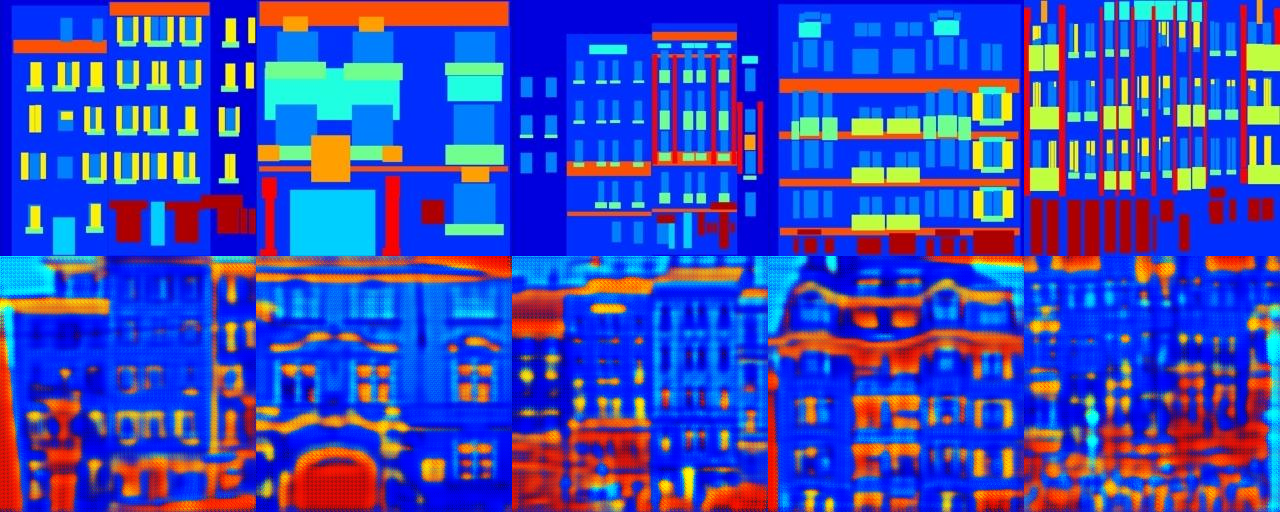

In [85]:
validate_generator(G_segmentation, val_dataloader, cfg.CYCLEGAN.RESULTS_PATH)

# 4. Conclusions
# Results
#### As a result, We obtained 2 models: Pix2Pix and CycleGAN.
#### Pix2Pix was way faster to train, unfortunately, I couldnt train CycleGAN for enough epochs to compare them in a good way(1 epoch vs 100 epochs).

#### During working on this project I understood, how these models differ. Pix2Pix gives us kind of blurry results, but is way easier to train. In the case of CycleGAN, it doesn't need pairs of images for training, yet the training is super slow, but the performance is still reasonable.